In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.datasets import GraphDataset

%reload_ext autoreload
%autoreload 2

In [2]:
from NEExT.outliers.benchmark_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.outliers.benchmark_utils.embed import build_features
from NEExT.outliers.benchmark_utils.embed import build_embeddings
from NEExT.outliers.benchmark_utils.supervised import supervised_eval

graph_io = GraphIO()
hide_frac = {0: 0.8, 1: 0.8}
k_hop = 1

# edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

In [3]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
egonet_collection = EgonetCollection(egonet_feature_target='is_outlier', skip_features=graph_data['skip_features'])
egonet_collection.compute_k_hop_egonets(graph_collection, k_hop)
structural_features, features = build_features(egonet_collection, feature_vector_length=k_hop, feature_list=graph_data["feature_list"])

In [4]:
embeddings = build_embeddings(
    egonet_collection,
    structural_features,
    features,
    strategy="structural_embeddings",
    embeddings_dimension=5,
    embeddings_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = GraphDataset(egonet_collection, embeddings, standardize=False)

In [5]:
model = "lgbm"
out_df, score = supervised_eval(model, ground_truth_df, dataset)
score

[I 2025-04-05 17:06:18,952] A new study created in memory with name: no-name-74ad8c42-d6f0-44a0-baf4-2b9e02be94ee


[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 17:06:23,272] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 10, 'min_data_in_leaf': 7, 'num_leaves': 82, 'max_depth': 68, 'class_weight': None, 'learning_rate': 0.0068277700401591455, 'colsample_bytree': 0.4879267709334689}. Best is trial 2 with value: 0.5.
[I 2025-04-05 17:06:23,332] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 66, 'min_data_in_leaf': 5, 'num_leaves': 55, 'max_depth': 29, 'class_weight': 'balanced', 'learning_rate': 0.0008155342697097357, 'colsample_bytree': 0.8519301863154141}. Best is trial 2 with value: 0.5.
[I 2025-04-05 17:06:23,376] Trial 5 finished with value: 0.859375 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 1, 'num_leaves': 86, 'max_depth': 97, 'class_weight': None, 'learning_rate': 5.295290901234323, 'colsample_bytree': 0.2719915667028143}. Best is trial 5 with value: 0.859375.


[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 17:06:23,434] Trial 6 finished with value: 0.5 and parameters: {'n_estimators': 70, 'min_data_in_leaf': 6, 'num_leaves': 68, 'max_depth': 93, 'class_weight': 'balanced', 'learning_rate': 0.00026705971077202147, 'colsample_bytree': 0.552754519681119}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:23,484] Trial 7 finished with value: 0.5 and parameters: {'n_estimators': 65, 'min_data_in_leaf': 8, 'num_leaves': 47, 'max_depth': 100, 'class_weight': None, 'learning_rate': 1.7735047814072507e-05, 'colsample_bytree': 0.8540745606172744}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:23,524] Trial 8 finished with value: 0.7 and parameters: {'n_estimators': 2, 'min_data_in_leaf': 3, 'num_leaves': 82, 'max_depth': 94, 'class_weight': None, 'learning_rate': 5.5459227049244495, 'colsample_bytree': 0.5821903058318997}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:23,563] Trial 9 finished with value: 0.6875 and parameters: {'n_estimators': 6, 'min_

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further

[I 2025-04-05 17:06:23,681] Trial 12 finished with value: 0.759375 and parameters: {'n_estimators': 70, 'min_data_in_leaf': 4, 'num_leaves': 80, 'max_depth': 77, 'class_weight': 'balanced', 'learning_rate': 5.540743153055303, 'colsample_bytree': 0.5551089854401665}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:23,768] Trial 13 finished with value: 0.5 and parameters: {'n_estimators': 27, 'min_data_in_leaf': 1, 'num_leaves': 11, 'max_depth': 43, 'class_weight': None, 'learning_rate': 0.1049042678064715, 'colsample_bytree': 0.24923479597158027}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:23,863] Trial 14 finished with value: 0.809375 and parameters: {'n_estimators': 37, 'min_data_in_leaf': 1, 'num_leaves': 99, 'max_depth': 68, 'class_weight': 'balanced', 'learning_rate': 8.248726570926866, 'colsample_bytree': 0.23964818618378048}. Best is trial 5 with value: 0.859375.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[6]	valid_0's auc: 0.96875
[LightGBM] [Info] Number of positive: 24, n

[I 2025-04-05 17:06:23,926] Trial 15 finished with value: 0.5 and parameters: {'n_estimators': 35, 'min_data_in_leaf': 1, 'num_leaves': 99, 'max_depth': 59, 'class_weight': 'balanced', 'learning_rate': 0.08792253021361782, 'colsample_bytree': 0.20818918854072885}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:23,951] Trial 0 finished with value: 0.771875 and parameters: {'n_estimators': 17, 'min_data_in_leaf': 3, 'num_leaves': 89, 'max_depth': 13, 'class_weight': 'balanced', 'learning_rate': 6.546352757715563, 'colsample_bytree': 0.8320376526908797}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,012] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 10, 'min_data_in_leaf': 4, 'num_leaves': 46, 'max_depth': 30, 'class_weight': None, 'learning_rate': 0.02262046732116781, 'colsample_bytree': 0.29874151410771255}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,058] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 31,

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 17:06:24,128] Trial 16 finished with value: 0.646875 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 2, 'num_leaves': 100, 'max_depth': 2, 'class_weight': None, 'learning_rate': 0.4012159200918887, 'colsample_bytree': 0.3492625961991184}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,166] Trial 17 finished with value: 0.61875 and parameters: {'n_estimators': 47, 'min_data_in_leaf': 2, 'num_leaves': 98, 'max_depth': 74, 'class_weight': None, 'learning_rate': 0.3333165918554504, 'colsample_bytree': 0.3536172151313999}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,260] Trial 18 finished with value: 0.71875 and parameters: {'n_estimators': 46, 'min_data_in_leaf': 2, 'num_leaves': 97, 'max_depth': 76, 'class_weight': None, 'learning_rate': 1.0395503649513456, 'colsample_bytree': 0.3854441209280459}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,294] Trial 19 finished with value: 0.659375 and parameters: {'n_estimators': 45

idation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-04-05 17:06:24,364] Trial 20 finished with value: 0.65 and parameters: {'n_estimators': 49, 'min_data_in_leaf': 2, 'num_leaves': 92, 'max_depth': 77, 'class_weight': 'balanced', 'learning_rate': 0.8540787207765655, 'colsample_bytree': 0.435664736769474}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,388] Trial 21 finished with value: 0.6875 and parameters: {'n_estimators': 22, 'min_data_in_leaf': 1, 'num_leaves': 27, 'max_depth': 50, 'class_weight': 'balanced', 'learning_rate': 1.7131268597969092, 'colsample_bytree': 0.7067238887418297}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,500] Trial 22 finished with value: 0.5 and parameters: {'n_estimators': 23, 'min_data_in_leaf': 1, 'num_leaves': 29, 'max_depth': 51, 'class_weight': 'balanced', 'learning_rate': 0.05256379068993181, 'colsample_bytree': 0.6567685455209944}. Best is trial 5 with value: 0.859375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can

[I 2025-04-05 17:06:24,528] Trial 23 finished with value: 0.5 and parameters: {'n_estimators': 23, 'min_data_in_leaf': 1, 'num_leaves': 31, 'max_depth': 50, 'class_weight': 'balanced', 'learning_rate': 0.0769860786929406, 'colsample_bytree': 0.7262906413622008}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,587] Trial 24 finished with value: 0.596875 and parameters: {'n_estimators': 15, 'min_data_in_leaf': 1, 'num_leaves': 88, 'max_depth': 7, 'class_weight': 'balanced', 'learning_rate': 9.636443291234633, 'colsample_bytree': 0.7251486804236864}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,636] Trial 25 finished with value: 0.528125 and parameters: {'n_estimators': 19, 'min_data_in_leaf': 3, 'num_leaves': 88, 'max_depth': 2, 'class_weight': 'balanced', 'learning_rate': 9.238828582899663, 'colsample_bytree': 0.7335836667634705}. Best is trial 5 with value: 0.859375.


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -

[I 2025-04-05 17:06:24,829] Trial 26 finished with value: 0.69375 and parameters: {'n_estimators': 18, 'min_data_in_leaf': 3, 'num_leaves': 90, 'max_depth': 3, 'class_weight': 'balanced', 'learning_rate': 7.234848311480124, 'colsample_bytree': 0.9785567537822077}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,852] Trial 27 finished with value: 0.528125 and parameters: {'n_estimators': 56, 'min_data_in_leaf': 3, 'num_leaves': 91, 'max_depth': 2, 'class_weight': 'balanced', 'learning_rate': 8.827451513681869, 'colsample_bytree': 0.7886605884418327}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,902] Trial 28 finished with value: 0.771875 and parameters: {'n_estimators': 40, 'min_data_in_leaf': 3, 'num_leaves': 71, 'max_depth': 14, 'class_weight': 'balanced', 'learning_rate': 3.1293019120542604, 'colsample_bytree': 0.9974814553315927}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:24,930] Trial 29 finished with value: 0.8375 and parameters: {'n_es

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with

[I 2025-04-05 17:06:25,116] Trial 30 finished with value: 0.80625 and parameters: {'n_estimators': 39, 'min_data_in_leaf': 3, 'num_leaves': 72, 'max_depth': 20, 'class_weight': 'balanced', 'learning_rate': 2.487089450830191, 'colsample_bytree': 0.27212455294453947}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,140] Trial 31 finished with value: 0.8375 and parameters: {'n_estimators': 39, 'min_data_in_leaf': 6, 'num_leaves': 71, 'max_depth': 38, 'class_weight': None, 'learning_rate': 2.305772094999875, 'colsample_bytree': 0.9856055453244243}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,188] Trial 32 finished with value: 0.5 and parameters: {'n_estimators': 39, 'min_data_in_leaf': 5, 'num_leaves': 74, 'max_depth': 87, 'class_weight': None, 'learning_rate': 0.014379865990457472, 'colsample_bytree': 0.3135646490870662}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,234] Trial 33 finished with value: 0.5 and parameters: {'n_estimators': 56, 'm

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -

[I 2025-04-05 17:06:25,412] Trial 34 finished with value: 0.80625 and parameters: {'n_estimators': 40, 'min_data_in_leaf': 5, 'num_leaves': 61, 'max_depth': 20, 'class_weight': 'balanced', 'learning_rate': 2.470033369265258, 'colsample_bytree': 0.2767440914515208}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,448] Trial 35 finished with value: 0.5 and parameters: {'n_estimators': 54, 'min_data_in_leaf': 6, 'num_leaves': 64, 'max_depth': 38, 'class_weight': None, 'learning_rate': 0.1890159927076269, 'colsample_bytree': 0.9323597404862534}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,497] Trial 36 finished with value: 0.5 and parameters: {'n_estimators': 32, 'min_data_in_leaf': 6, 'num_leaves': 61, 'max_depth': 39, 'class_weight': None, 'learning_rate': 0.16988340337149438, 'colsample_bytree': 0.9606268182430422}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,538] Trial 37 finished with value: 0.65625 and parameters: {'n_estimators': 33, 'm

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-04-05 17:06:25,718] Trial 38 finished with value: 0.640625 and parameters: {'n_estimators': 33, 'min_data_in_leaf': 7, 'num_leaves': 83, 'max_depth': 37, 'class_weight': None, 'learning_rate': 3.7019562930073966, 'colsample_bytree': 0.9311381267586868}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,778] Trial 39 finished with value: 0.69375 and parameters: {'n_estimators': 33, 'min_data_in_leaf': 7, 'num_leaves': 84, 'max_depth': 36, 'class_weight': None, 'learning_rate': 4.120140538699006, 'colsample_bytree': 0.912912147879224}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,799] Trial 40 finished with value: 0.696875 and parameters: {'n_estimators': 75, 'min_data_in_leaf': 8, 'num_leaves': 83, 'max_depth': 64, 'class_weight': None, 'learning_rate': 0.9905053903852687, 'colsample_bytree': 0.4589169761390841}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:25,884] Trial 41 finished with value: 0.5 and parameters: {'n_estimators': 63, 'min

[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early 

[I 2025-04-05 17:06:26,039] Trial 42 finished with value: 0.5 and parameters: {'n_estimators': 62, 'min_data_in_leaf': 8, 'num_leaves': 76, 'max_depth': 63, 'class_weight': None, 'learning_rate': 0.00011061030066407636, 'colsample_bytree': 0.8931881290674584}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:26,080] Trial 43 finished with value: 0.5 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 2, 'num_leaves': 77, 'max_depth': 65, 'class_weight': None, 'learning_rate': 0.00011513964306137966, 'colsample_bytree': 0.20759869337296125}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:26,125] Trial 44 finished with value: 0.5 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 4, 'num_leaves': 77, 'max_depth': 23, 'class_weight': 'balanced', 'learning_rate': 6.0417130033783425e-05, 'colsample_bytree': 0.23180394792723538}. Best is trial 5 with value: 0.859375.


[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-04-05 17:06:26,198] Trial 45 finished with value: 0.5 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 2, 'num_leaves': 75, 'max_depth': 24, 'class_weight': 'balanced', 'learning_rate': 8.437088293971911e-05, 'colsample_bytree': 0.21650683860611952}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:26,352] Trial 46 finished with value: 0.7875 and parameters: {'n_estimators': 43, 'min_data_in_leaf': 4, 'num_leaves': 69, 'max_depth': 24, 'class_weight': 'balanced', 'learning_rate': 1.3175908938648946, 'colsample_bytree': 0.21034271594512613}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:26,362] Trial 47 finished with value: 0.778125 and parameters: {'n_estimators': 52, 'min_data_in_leaf': 4, 'num_leaves': 55, 'max_depth': 24, 'class_weight': 'balanced', 'learning_rate': 1.626138838550982, 'colsample_bytree': 0.8127240035929828}. Best is trial 5 with value: 0.859375.
[I 2025-04-05 17:06:26,398] Trial 48 finished with value: 0.70625 and parameters: {'n

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 24, number of negative: 96
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

0.855

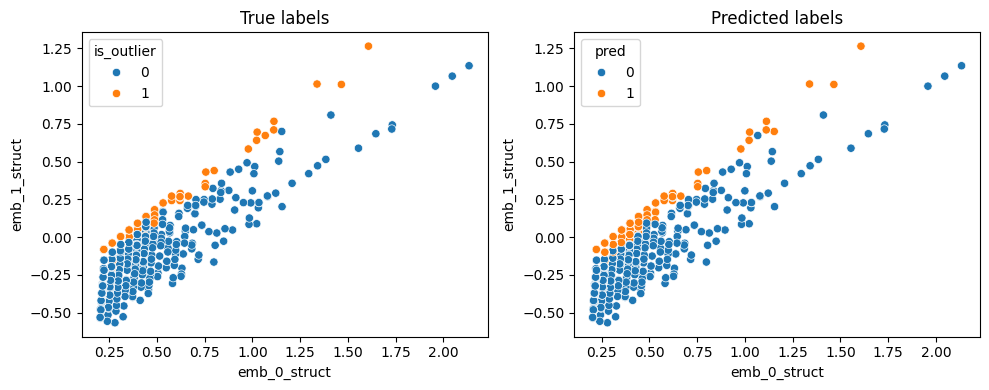

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


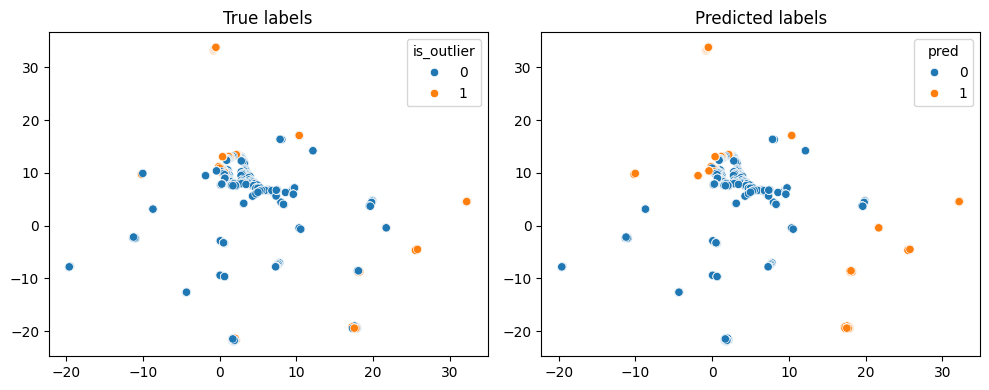

In [7]:
import umap

reduced = umap.UMAP().fit_transform(embeddings.embeddings_df.iloc[:, 1:])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()